# Import libraries

In [5]:
import torch,torchvision
import torch.nn as nn
import torch.optim as optim

import torchvision.datasets as data
import torchvision.transforms as transforms

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda:0


In [7]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)  # 10 output classes for digits 0-9

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = x.view(-1, 64 * 7 * 7)  # Reshape for fully connected layer
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)

        return x

# Dataset loading and downloading

In [8]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
train_data = data.MNIST('mnist_data',train=True,download=True,transform=transform)
test_data = data.MNIST('mnist_data',train=False,download=True,transform=transform)

# Data samples

The shape of the image:  torch.Size([1, 28, 28])
The number of training images:  60000
The number of training images:  10000




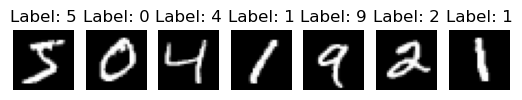

In [9]:
num_samples = 7

print("The shape of the image: ",train_data[0][0].shape)
print("The number of training images: ",len(train_data))
print("The number of training images: ",len(test_data))
print("\n")
for i in range(num_samples):
    image, label = train_data[i]
    image = image.numpy().squeeze()
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')

plt.show()

# Data loader with batch_size 64

In [10]:
train_dataloader = torch.utils.data.DataLoader(train_data,batch_size=64)
test_dataloader = torch.utils.data.DataLoader(test_data,batch_size=64)

In [11]:
mnist_model = SimpleCNN().to(device)

In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(mnist_model.parameters(), lr=0.001)

In [13]:
num_epochs = 5

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for batch_idx, data in enumerate(train_dataloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = mnist_model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        # Print loss and accuracy every N batches
        if batch_idx % 500 == 0:  # Adjust the interval as needed
            average_loss = running_loss / 100  # Average loss per batch
            accuracy = correct_predictions / total_samples
            print(f'Epoch {epoch + 1}, Batch {batch_idx + 1}, Loss: {average_loss:.4f}, Accuracy: {accuracy * 100:.2f}%')

Epoch 1, Batch 1, Loss: 0.0231, Accuracy: 4.69%
Epoch 1, Batch 501, Loss: 1.2153, Accuracy: 93.00%
Epoch 2, Batch 1, Loss: 0.0005, Accuracy: 98.44%
Epoch 2, Batch 501, Loss: 0.2529, Accuracy: 98.47%
Epoch 3, Batch 1, Loss: 0.0001, Accuracy: 100.00%
Epoch 3, Batch 501, Loss: 0.1570, Accuracy: 99.08%
Epoch 4, Batch 1, Loss: 0.0001, Accuracy: 100.00%
Epoch 4, Batch 501, Loss: 0.1055, Accuracy: 99.39%
Epoch 5, Batch 1, Loss: 0.0003, Accuracy: 98.44%
Epoch 5, Batch 501, Loss: 0.0759, Accuracy: 99.54%


In [14]:
mnist_model.eval()
all_labels = []
all_predictions = []


In [15]:
with torch.no_grad():
    for data in test_dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = mnist_model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_labels = np.append(all_labels, labels.cpu().numpy())
        all_predictions = np.append(all_predictions, predicted.cpu().numpy())

# Handle the case where there might be empty slices
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

Accuracy: 98.92%
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.97      0.99      0.98      1032
           3       1.00      0.98      0.99      1010
           4       0.99      1.00      0.99       982
           5       0.98      0.99      0.99       892
           6       1.00      0.98      0.99       958
           7       0.99      0.98      0.98      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



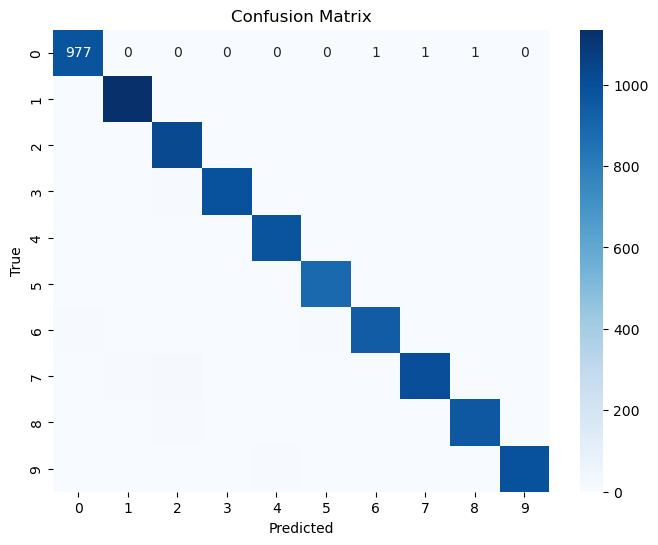

In [16]:
accuracy = accuracy_score(all_labels, all_predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Display classification report
print("Classification Report:")
print(classification_report(all_labels, all_predictions, target_names=[str(i) for i in range(10)]))

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Prediction: 1


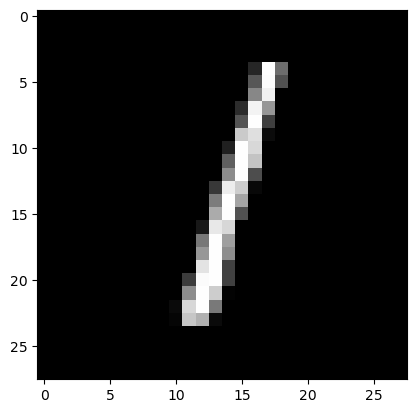

In [17]:
mnist_model.eval()
data, label = test_data[2]
data = data.unsqueeze(0).to(device)  # Assign the transformed data back to the variable

output = mnist_model(data)
prediction = output.argmax(dim=1, keepdim=True).item()
print(f'Prediction: {prediction}')
image = data.squeeze(0).squeeze(0).cpu().numpy()
plt.imshow(image, cmap='gray')
plt.show()


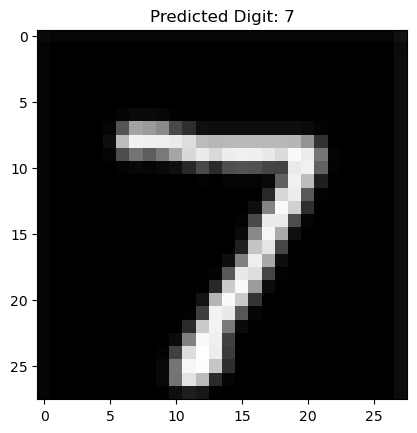

In [38]:
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess the image
new_image_path = r"D:\programs\DeepLearning\mnist\digitRecognition\num7.png"
new_img = Image.open(new_image_path).convert('L')  
new_img = new_img.resize((28, 28))  
new_img_np = np.array(new_img) / 255.0
flattened_image = new_img_np.flatten()

# Reshape for model input
model_input = flattened_image.reshape(1, 1, 28, 28).astype(np.float32)  # Assuming your model expects a batch dimension and 1 channel

# Convert to PyTorch tensor
model_input = torch.tensor(model_input)

# Move the model and input tensor to the same device (CPU or GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
mnist_model = mnist_model.to(device)
model_input = model_input.to(device)

# Make predictions
with torch.no_grad():
    mnist_model.eval()
    outputs = mnist_model(model_input)

_, predicted = torch.max(outputs.data, 1)
predicted_digit = predicted.item()

# Display the image and the predicted digit
plt.imshow(new_img_np, cmap='gray')
plt.title(f'Predicted Digit: {predicted_digit}')
plt.show()
